Part 1 and 2: Set up data loader to take in and split fingerprint recognition dataset.

In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install the ART library (provides adversarial attacks)
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00


In [3]:
# Import libraries

import os
from os import listdir
import cv2
import natsort
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
from os import listdir
from sklearn.model_selection import train_test_split
import natsort
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model

# This line is important when using the Keras ART classifier
# Also, this line needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.15.0


In [9]:



# Function to load images and assign labels
def load_images_and_labels(directory):
    imgs_list = []
    labels_list = []
    filenames_list = []

    # List of all images in the directory
    imgs_list_1 = listdir(directory)
    # sort the images
    imagesList = natsort.natsorted(imgs_list_1)

    # Read as numpy arrays
    label = 0
    for idx, filename in enumerate(imagesList):
        # index module by 8, to represent the 8 images of each fingerprint
        if idx % 8 == 0 and idx != 0:
            label += 1
        # Read the image
        tmp_img = cv2.imread(os.path.join(directory, filename))
        imgs_list.append(np.array(tmp_img / 255.))
        labels_list.append(label)
        filenames_list.append(filename)

    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)
    filenames = np.asarray(filenames_list)

    return imgs, labels, filenames

# Data directory for fingerprint recognition dataset
data_path = "/content/drive/MyDrive/AML_Course/Spring_2024/Final_Project/Db1_a"

# Load the images with labels grouped into classes of 8 images
all_images, all_labels, all_filenames = load_images_and_labels(data_path)

# Split into train and test sets
train_images, test_images, train_labels, test_labels, train_filenames, _ = train_test_split(all_images, all_labels, all_filenames, test_size=0.2, random_state=12)
del all_images, all_labels, all_filenames




In [ ]:
# Define class names
class_names = np.unique(train_labels)
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (640, 374, 388, 3) - Labels train shape: (640,)
Images test shape: (160, 374, 388, 3) - Labels test shape: (160,)

Max pixel value 0.996078431372549
Min pixel value 0.00392156862745098
Average pixel value 0.8476401030316484
Data type float64


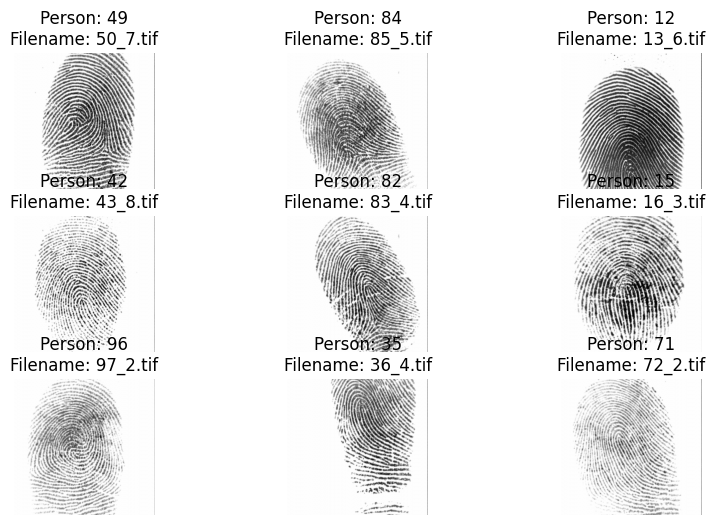

In [ ]:
import matplotlib.pyplot as plt

# Plot images and labels
plt.figure(figsize=(10, 6))
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    i = n * 8  # first image of each group of 8
    plt.imshow(train_images[i])
    label = train_labels[i]
    filename = train_filenames[i]
    plt.title('Person: ' + str(label) + '\nFilename: ' + filename)
    plt.axis('off')
plt.show()


In [4]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam as LegacyAdam

import datetime
now = datetime.datetime.now

In [14]:
#!pip install tf-keras

In [ ]:

import datetime
now = datetime.datetime.now

# Define base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(374, 388, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add fully-connected layers
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)

# Add a softmax layer with 100 classes
predictions = Dense(100, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5) 

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Define early stopping callback
callbacks = [EarlyStopping(monitor='val_loss', patience=30)]




# Fit the model
start_time = datetime.datetime.now()
history = model.fit(train_images, train_labels, epochs=100, batch_size=8,
                    validation_data=(test_images, test_labels), verbose=1, callbacks=callbacks)
end_time = datetime.datetime.now()
print('Training time:', end_time - start_time)


Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - ETA: 0s - loss: 4.6525 - accuracy: 0.0109

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


640/640 [==============================] - 53s 83ms/sample - loss: 4.6525 - accuracy: 0.0109 - val_loss: 4.6308 - val_accuracy: 0.0125
Epoch 2/100
640/640 [==============================] - 35s 54ms/sample - loss: 4.6309 - accuracy: 0.0172 - val_loss: 4.6149 - val_accuracy: 0.0125
Epoch 3/100
640/640 [==============================] - 35s 55ms/sample - loss: 4.6071 - accuracy: 0.0094 - val_loss: 4.6102 - val_accuracy: 0.0125
Epoch 4/100
640/640 [==============================] - 35s 54ms/sample - loss: 4.6055 - accuracy: 0.0125 - val_loss: 4.5933 - val_accuracy: 0.0125
Epoch 5/100
640/640 [==============================] - 35s 55ms/sample - loss: 4.5613 - accuracy: 0.0094 - val_loss: 4.5511 - val_accuracy: 0.0312
Epoch 6/100
640/640 [==============================] - 35s 54ms/sample - loss: 4.4813 - accuracy: 0.0281 - val_loss: 4.4486 - val_accuracy: 0.0375
Epoch 7/100
640/640 [==============================] - 35s 55ms/sample - loss: 4.3095 - accuracy: 0.0453 - val_loss: 4.2955 - val_

In [ ]:
def plot_accuracy_loss(the_history):
    # Plot the accuracy and loss
    train_loss = the_history.history['loss']
    val_loss = the_history.history['val_loss']
    acc = the_history.history['accuracy']
    val_acc = the_history.history['val_accuracy']

    epochs = np.arange(1, len(train_loss) + 1, 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


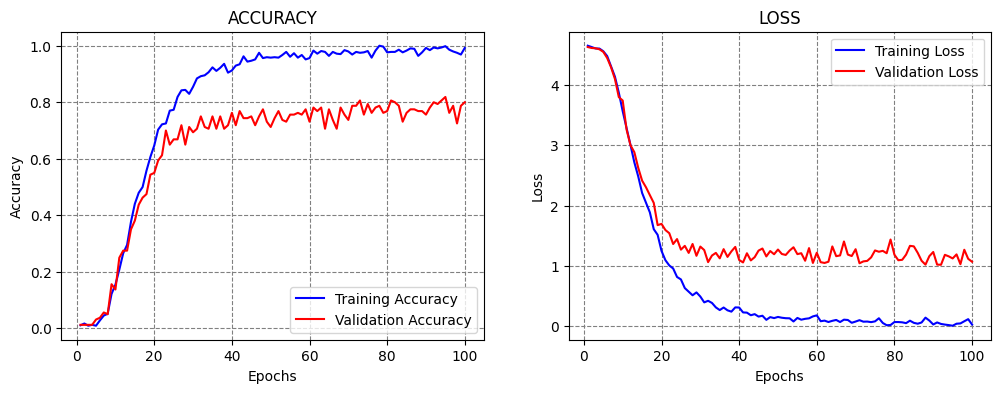

Test Accuracy: 0.8
Test Loss: 1.0704488515853883


In [ ]:


# Plot accuracy and loss
plot_accuracy_loss(history)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

In [ ]:
# path to google drive
drive_path = '/content/drive/MyDrive/AML_Course/Spring_2024/Final_Project/'

# Save trained model in google drive
model.save(drive_path + "model.h5")

# Save model weights in google drive
model.save_weights(drive_path + "weights.h5")

# Save training history in google drive
np.save(drive_path + "history.npy", history.history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from tensorflow.keras.models import load_model


# path in google drive
drive_path = '/content/drive/MyDrive/AML_Course/Spring_2024/Final_Project/'

# load model
loaded_model = load_model(drive_path + "model.h5")

model = loaded_model

# Load weights
model.load_weights(drive_path + "weights.h5")

# Load training history
history = np.load(drive_path + "history.npy", allow_pickle='TRUE').item()

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 374, 388, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 374, 388, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 374, 388, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 187, 194, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 187, 194, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 187, 194, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 93, 97, 128)       0   

Part 3: Implement PGD Attack

In [ ]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
# Use the first 200 test images for creating adversarial samples
adv_imgs = test_images[0:200]
adv_labels = test_labels[0:200]

PGD Attack:



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 76.25%
Average perturbation: 0.00


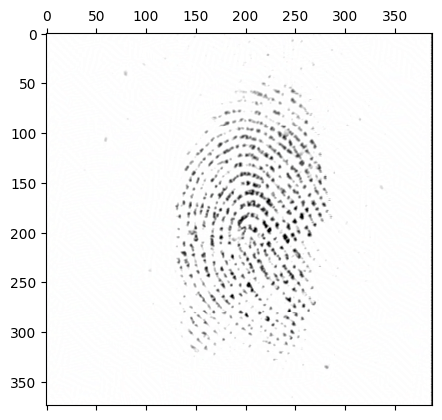

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 61.25%
Average perturbation: 0.01


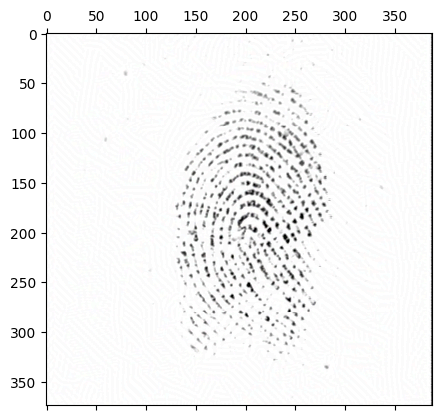

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 43.13%
Average perturbation: 0.01


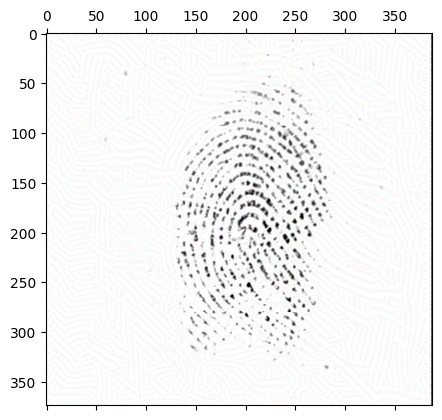

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 20.00%
Average perturbation: 0.02


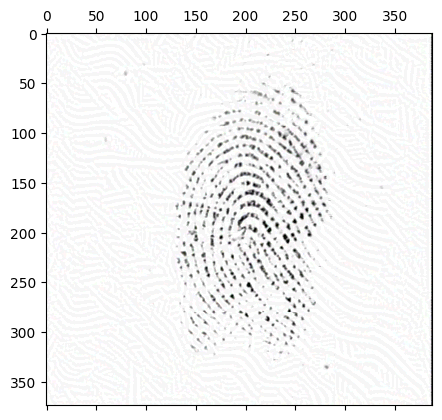

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 1.88%
Average perturbation: 0.05


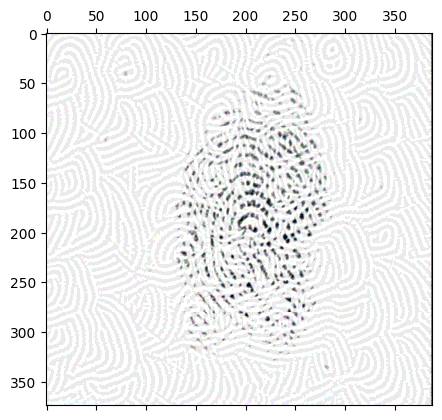

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.63%
Average perturbation: 0.12


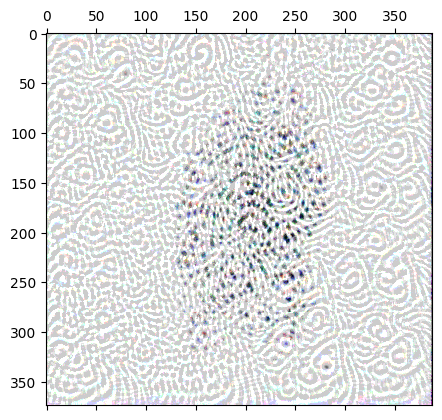

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.18


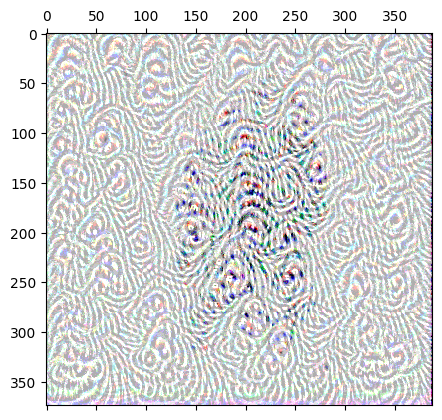

In [ ]:
# PGD attack
print("PGD Attack:\n")
epsilon = [1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]
pgd_attack_acc = []
for eps in epsilon:
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=eps)
    pgd_attack_adv_imgs = attack_pgd.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs, adv_labels)
    pgd_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((pgd_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(pgd_attack_adv_imgs[0]))
    plt.show()

Part 4: Perform FGSM attack.

FGSM Attack: 

Accuracy on adversarial test data: 75.63%
Average perturbation: 0.00


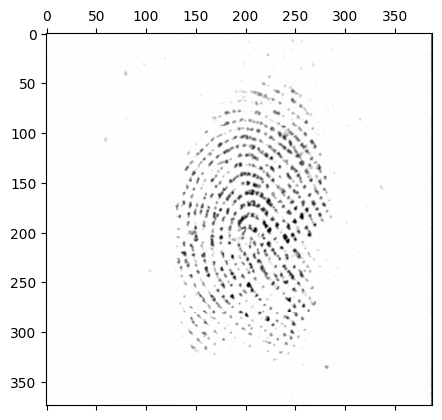

Accuracy on adversarial test data: 63.13%
Average perturbation: 0.01


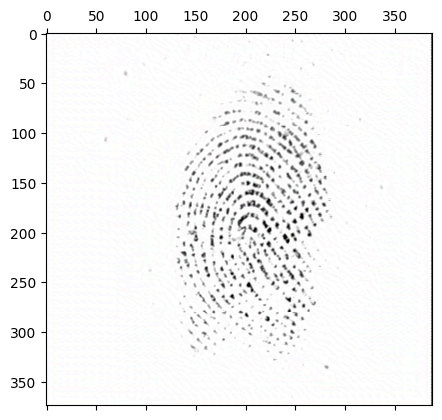

Accuracy on adversarial test data: 50.00%
Average perturbation: 0.01


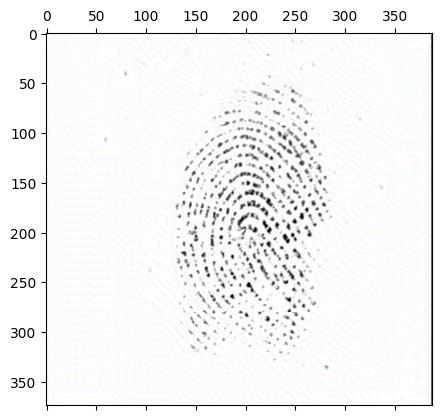

Accuracy on adversarial test data: 33.13%
Average perturbation: 0.02


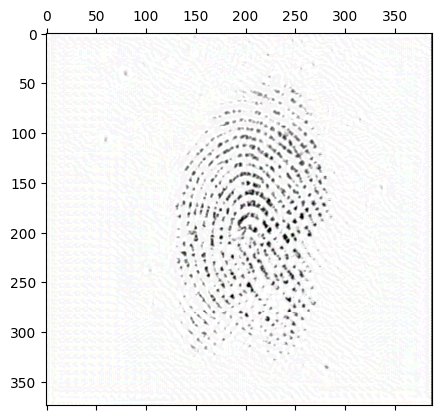

Accuracy on adversarial test data: 9.38%
Average perturbation: 0.05


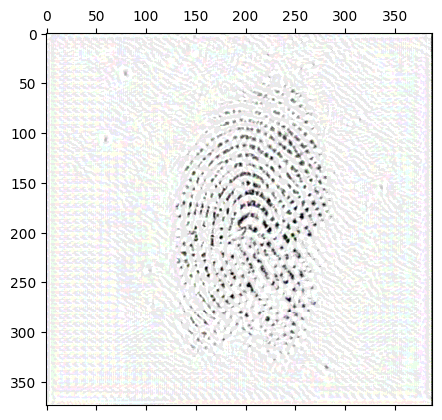

Accuracy on adversarial test data: 1.25%
Average perturbation: 0.13


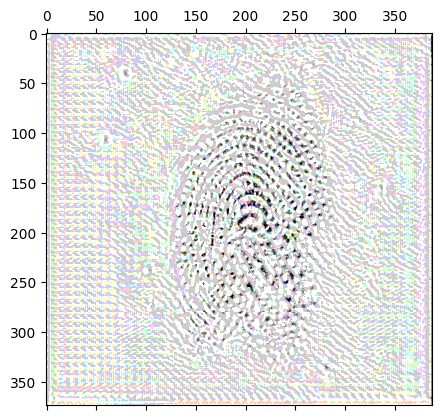

Accuracy on adversarial test data: 1.25%
Average perturbation: 0.20


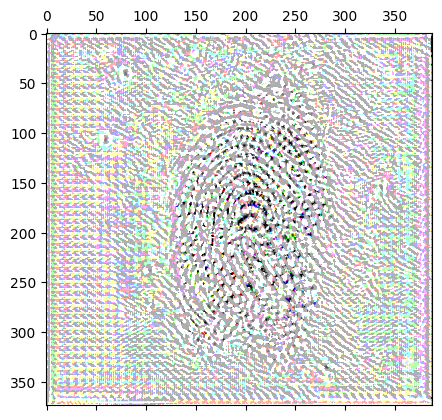

In [ ]:
# FGSM attack
print("FGSM Attack: \n")
epsilon = [1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

fgsm_attack_acc = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs, adv_labels)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))
    plt.show()

Part 5: Perform HopSkipJump attack.

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


HopSkipJump:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy on adversarial test data: 0.00%


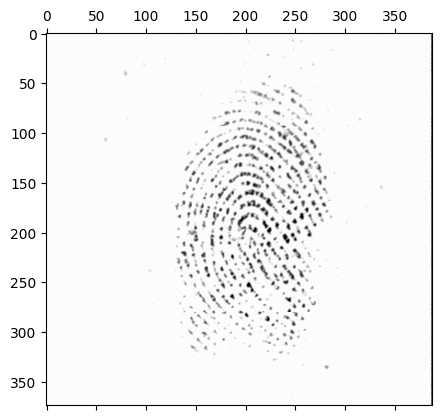

In [12]:
# Use the first 2 test images for creating adversarial samples
adv_imgs = test_images[0:2]
adv_labels = test_labels[0:2]

#perform HopSkipJump attack
import art.attacks.evasion as HopSkipJump
from art.estimators.classification import KerasClassifier

classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True)
hskj_attack = HopSkipJump.HopSkipJump(classifier=classifier)

hskj_attack_adv_imgs = hskj_attack.generate(adv_imgs)
loss_test, accuracy_test = model.evaluate(hskj_attack_adv_imgs, adv_labels)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
plt.matshow(np.squeeze(hskj_attack_adv_imgs[0]))
plt.show()

Part 6: Perform Universal Perturbation attack.

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on adversarial test data: 50.00%


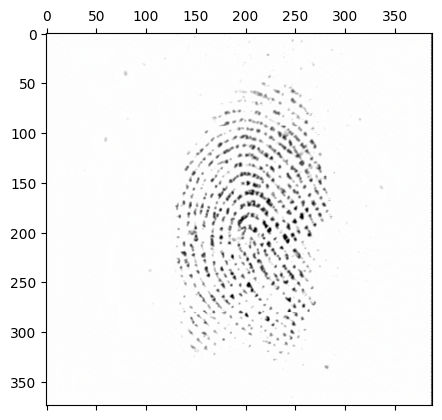

In [13]:
## Use the first 2 test images for creating adversarial samples
adv_imgs = test_images[0:2]
adv_labels = test_labels[0:2]

#perform universal perturbation attack
import art.attacks.evasion as UniversalPerturbation

classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True)
up_attack = UniversalPerturbation.UniversalPerturbation(classifier=classifier)

up_attack_adv_imgs = up_attack.generate(adv_imgs)
loss_test, accuracy_test = model.evaluate(up_attack_adv_imgs, adv_labels)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
plt.matshow(np.squeeze(up_attack_adv_imgs[0]))
plt.show()

Extra: Perform NewtonFool attack.

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


NewtonFool:   0%|          | 0/160 [00:00<?, ?it/s]

Accuracy on adversarial test data: 21.88%


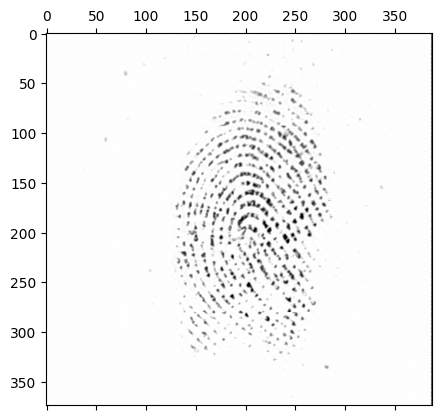

In [ ]:
#perform a newtonfool attack
import art.attacks.evasion as NewtonFool

classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True)

#NF
nf_attack = newtonfool.NewtonFool(classifier=classifier)

nf_attack_adv_imgs = nf_attack.generate(adv_imgs)
loss_test, accuracy_test = model.evaluate(nf_attack_adv_imgs, adv_labels)
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
plt.matshow(np.squeeze(nf_attack_adv_imgs[0]))
plt.show()